## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

-   shared/problem1-reg_data.csv – данные о времени регистрации

-   shared/problem1-auth_data.csv – данные о времени захода пользователей в игру
   
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
df_reg = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-fedorov/shared/problem1-reg_data.csv",sep=";")

In [3]:
df_auth = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-fedorov/shared/problem1-auth_data.csv",sep=";")

### Предобработка

In [4]:
df_reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [5]:
df_auth

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [6]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [8]:
df_reg.uid.value_counts()

2047      1
506274    1
502176    1
414111    1
416158    1
         ..
427642    1
431736    1
454263    1
452214    1
2049      1
Name: uid, Length: 1000000, dtype: int64

In [9]:
df_auth.uid.value_counts()

2         1929
108       1397
158       1367
176       1331
191       1296
          ... 
78835        1
119791       1
21471        1
13267        1
8196         1
Name: uid, Length: 1000000, dtype: int64

В данных о регистрации 1 млн уникальных записей пользователей, пустых значений не найдено. В данных о времени входа 9601013 записей пользователей, пустых значений не найдено, также в данном датасете встречается ровно 1 млн уникальных id пользователей, что говорит о том, что никакие записи не потерялись (должна в файле со временем входа присутствовать хотя бы одна запись, которая является временем регистрации). 

Стоит отметить, что время приведено в формате Unix timestamp в период с 1998.11.18 по 2020.09.23.



In [10]:
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.date

In [11]:
df_reg['reg_ts'].max()

datetime.date(2020, 9, 23)

In [12]:
df_reg['reg_ts'].min()

datetime.date(1998, 11, 18)

In [13]:
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date

In [14]:
df_auth['auth_ts'].max()

datetime.date(2020, 9, 23)

In [15]:
df_auth['auth_ts'].min()

datetime.date(1998, 11, 18)

Напишем функцию "retention" с входными параметрами :

-   путь к файлу со временем авторизации
-   путь к файлу со временем регистрации
-   начальная дата рассматриваемого временного промежутка
-   конечная дата рассматриваемого временного промежутка

In [16]:
def retention(auth_path, reg_path, start_date, final_date):
    
    # считываем датафрейм со времнем входа по пути файла
    df_auth = pd.read_csv(auth_path, sep=';')
    
    # считываем датафрейм с регистрацией по пути файла
    df_reg = pd.read_csv(reg_path, sep=';') 

    # переводим строковый формат стартовой даты во временной
    start_date = pd.to_datetime(start_date) 
    
    # переводим строковый формат конечной даты во временной
    final_date = pd.to_datetime(final_date) 

    # переводим Unix timestamp формат даты регистрации во временной
    df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.date
    
    # переводим Unix timestamp формат даты авторизации во временной
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date
    
    # выбираем в датафрейме регистрации временной промежуток, который больше старотовой даты
    df_reg = df_reg.loc[(df_reg['reg_ts'] >= start_date)] 
    
    # выбираем в датафрейме авторизации временной промежуток, который меньше конечной даты
    df_auth = df_auth.loc[(df_auth['auth_ts'] <= final_date)]
    
    all_data = df_auth.merge(df_reg, on='uid', how="inner") # соединяем два файла по uid

    # считаем временную разницу в днях для даты авторизации и регистрации
    all_data['date_diff'] = (all_data['auth_ts'] - all_data['reg_ts']).dt.days
    
    # формируем сводную таблицу для отслеживания retention rate
    data_pivot = all_data.pivot_table(index='reg_ts', columns='date_diff', values='uid', aggfunc='nunique')
    
    # записываем данные 0-го дня в отдельную переменную
    zero_day = data_pivot.iloc[:, 0]
    
    # формируем таблицу для подсчета Retention
    retention_table = data_pivot.divide(zero_day, axis=0)
    
    # строим тепловую карту для визуализации Retention игроков
    plt.figure(figsize=(20, 15))
    plt.title('Retention rate игроков c {} по {}'.format(start_date, final_date), fontsize=20)
    sns.heatmap(retention_table, vmin=0.0, vmax=0.1,
                linewidths=1, fmt='.2%', annot=True)
    plt.ylabel('Дата регистрации', fontsize=15) 
    plt.xlabel('Количество дней посещения игры с момента регистрации', fontsize=15)
    plt.show()

Тестируем

In [17]:
reg_path = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-fedorov/shared/problem1-reg_data.csv"
auth_path = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-fedorov/shared/problem1-auth_data.csv"

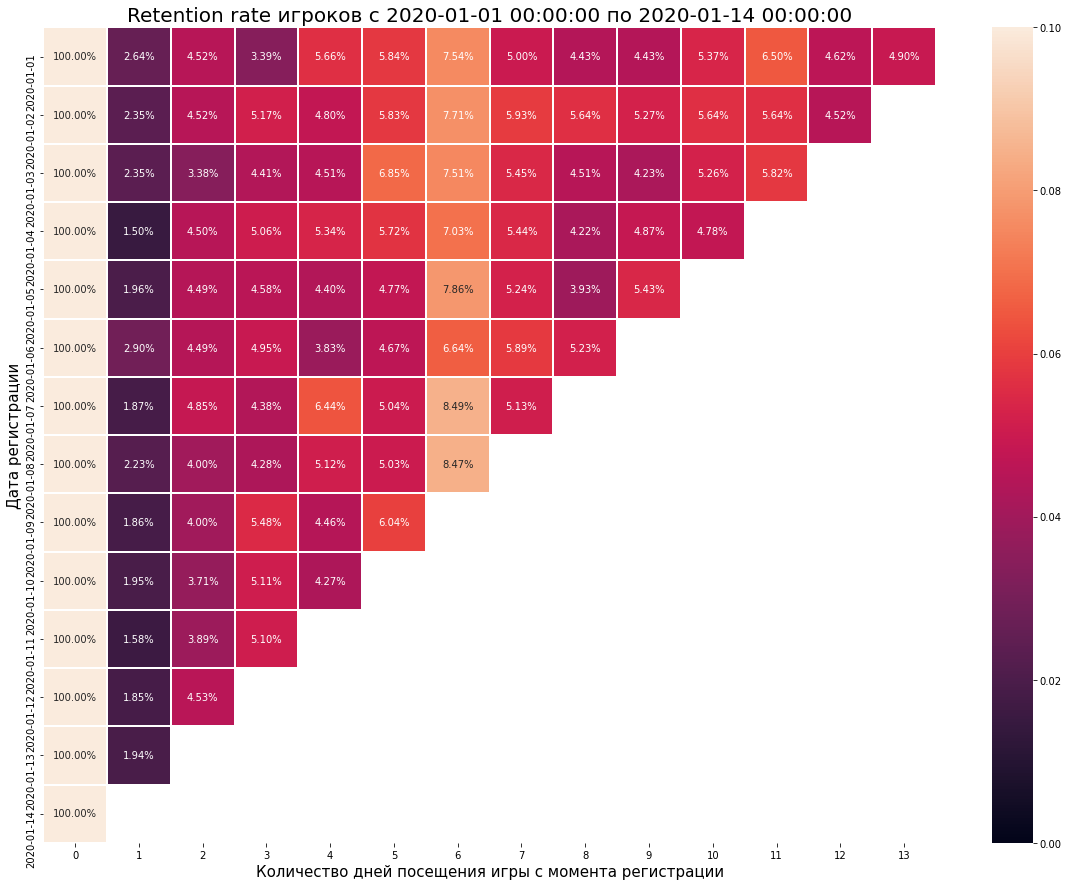

In [18]:
retention(auth_path, reg_path, '2020-01-01', '2020-01-14')

Для визуализации взят график, на котором отображен Retentionв период новогодних праздников 2020.01.01 по 2020.01.14
Заметно, что 6 января 2020 года был значительный приток, возможно это связано с тем, что в понедельник (6 января) вышел новый апдейт.